In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

# Feature Extraction

In [ ]:
def aggregate_features(df, window_size=10):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values(by=['id', 'datetime'])
    df['window'] = df.groupby('id')['datetime'].transform(lambda x: (x - x.min()).dt.total_seconds() // window_size)
    
    aggregated = df.groupby(['id', 'window']).agg({
        'X': ['mean', 'min', 'max', 'std'],
        'Y': ['mean', 'min', 'max', 'std'],
        'Z': ['mean', 'min', 'max', 'std'],
        'EDA': ['mean', 'min', 'max', 'std', skew, kurtosis],
        'HR': ['mean', 'min', 'max', 'std'],
        'TEMP': ['mean', 'min', 'max', 'std'],
        'label': 'first'  # Assume that the label does not change within a window
    })
    
    aggregated.columns = ['_'.join(col).strip() for col in aggregated.columns.values]
    aggregated.reset_index(inplace=True)
    
    return aggregated

TO DO: implement overlap windows using shift

In [3]:
data = pd.read_csv('merged_data.csv')
window_size = 10
result = aggregate_features(data, window_size=window_size)
result.drop(columns=['id', 'window'], axis=1, inplace=True)
print(result.shape)
result.to_csv(f'aggregated_data_{window_size}_window.csv', index=False)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_27240\3474319258.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('merged_data.csv')


(35850, 27)


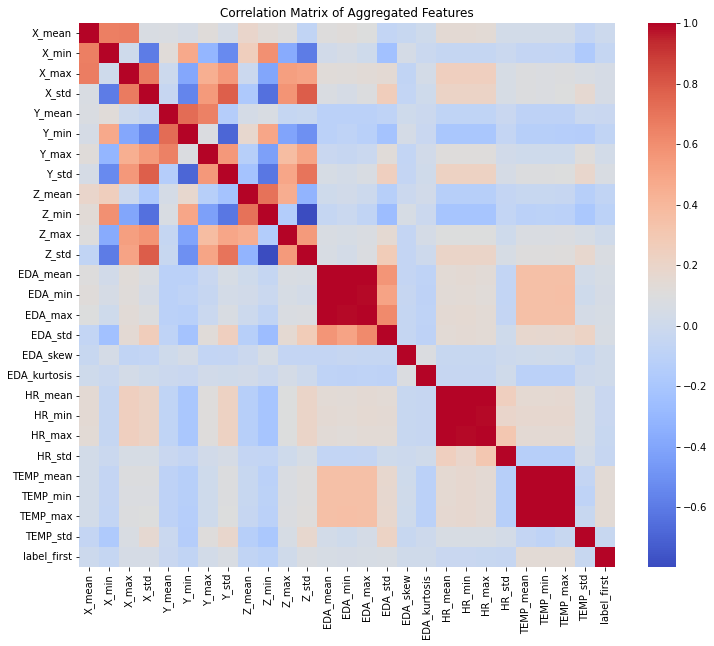

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = result.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=False, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Aggregated Features')
plt.show()

# Feature Selection

In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

In [5]:
def remove_highly_correlated_features(X, threshold=0.9):
    corr_matrix = X.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
    return X.drop(columns=to_drop, errors='ignore')

This method measures the dependence between each feature and the target variable. (on test)

In [ ]:
def feature_selection_mutual_info(X, y, top_k=10):
    mi_scores = mutual_info_classif(X, y, random_state=42)
    mi_scores_df = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
    selected_features = mi_scores_df[:top_k].index
    return X[selected_features]

c:\Users\Usuario\anaconda3\envs\stress\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def feature_selection(df):
    X = df.drop(columns=['label_first'])
    y = df['label_first']
    
    # Remove features with low variance
    selector = VarianceThreshold(threshold=0.01)
    X = pd.DataFrame(selector.fit_transform(X), columns=X.columns[selector.get_support()])
    
    # Eliminate highly correlated features
    X = remove_highly_correlated_features(X, threshold=0.9)
    
    # Normalize features
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    X_scaled.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_scaled.dropna(inplace=True)
    y = y.loc[X_scaled.index]
    
    return X_scaled, y

In [8]:
X_selected, y_selected = feature_selection(result)

# Model Implementation

In [9]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [27]:
def train_and_evaluate_models(X, y, test_size=0.2, random_state=42):
    models = {
        'SVM': SVC(probability=True, random_state=random_state),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=random_state),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=random_state),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=random_state),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=random_state)
    }
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    results = {}
    
    plt.figure(figsize=(10, 8))
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)

        report = classification_report(y_test, y_pred, output_dict=True)
        results[name] = report['weighted avg']
        results[name].update({'accuracy': report['accuracy']})
        df_report = pd.DataFrame(report).T
        df_report.to_csv(f'results/{name}_classification_report.csv', index=False)
        
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.savefig(f'results/{name}_confusion_matrix.png')
        
        if y_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1], pos_label=y.unique()[1])
            roc_auc = auc(fpr, tpr)
            results[name].update({'fpr': fpr, 'tpr': tpr, 'auc': roc_auc})

    plt.clf()
    plt.figure(figsize=(10, 6))
    for model, values in results.items():
        plt.plot(values['fpr'], values['tpr'], label=f'{model} (AUC = {values["auc"]:.2f})')
        
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend()
    plt.savefig('results/roc_curve_comparison.png')
    return results

c:\Users\Usuario\anaconda3\envs\stress\lib\site-packages\xgboost\core.py:158: UserWarning: [16:51:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 720x576 with 0 Axes>

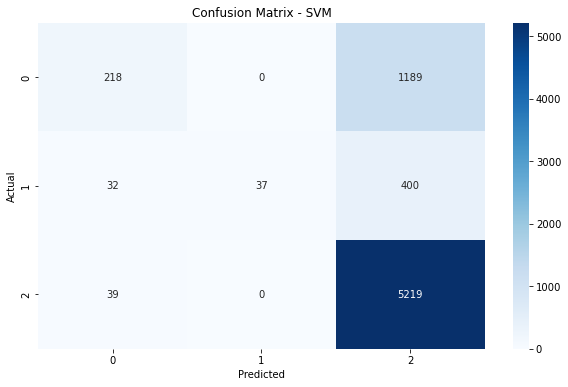

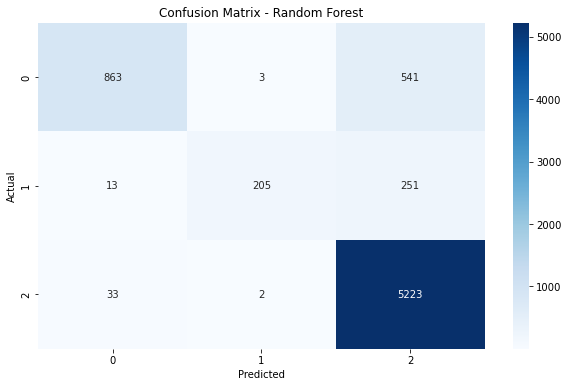

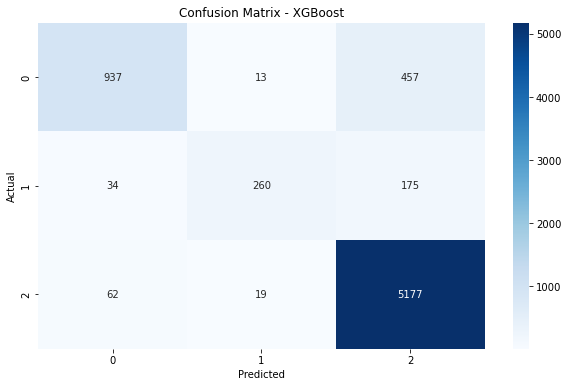

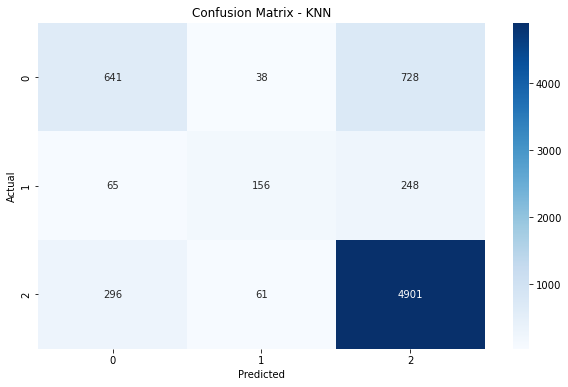

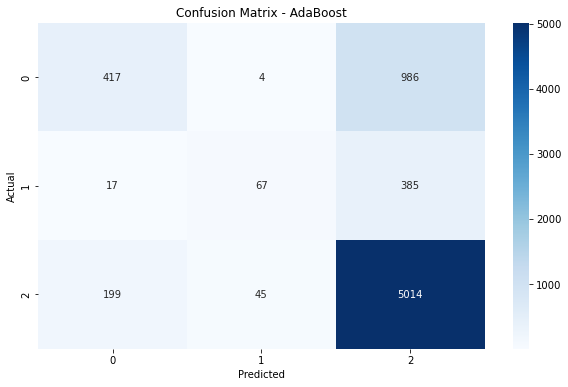

<Figure size 720x432 with 0 Axes>

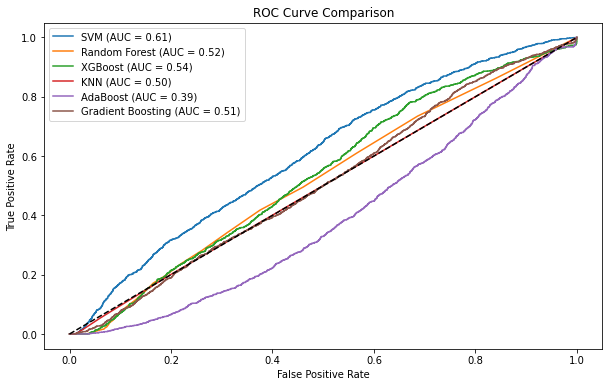

In [29]:
results = train_and_evaluate_models(X_selected, y_selected)

# Model Evaluation and Results

In [ ]:
def plot_model_comparison(classification_reports):
    metrics = ["precision", "recall", "f1-score", "accuracy"]
    models = list(classification_reports.keys())
    
    data = {metric: [classification_reports[model][metric] for model in models] for metric in metrics}
    df = pd.DataFrame(data, index=models)
    
    # Grouped Bar Chart
    fig, ax = plt.subplots(figsize=(12, 8))
    df.plot(kind='bar', width=0.7, colormap='viridis', edgecolor='black', alpha=0.75, ax=ax)
    plt.title("Comparison of Classification Metrics")
    plt.ylabel("Value")
    plt.xticks(rotation=45)
    plt.legend(title="Metric")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig('results/classification_metrics_bars.jpg', bbox_inches='tight')
    
    # Spider Chart
    categories = metrics
    num_vars = len(categories)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    for model, scores in df.iterrows():
        values = scores.tolist()
        values += values[:1]
        ax.plot(angles, values, label=model, linewidth=2)
        ax.fill(angles, values, alpha=0.2)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=12)
    ax.set_yticklabels([])
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    ax.set_title("Comparison of Classification Metrics")
    plt.savefig('results/classification_metrics_spider.jpg', bbox_inches='tight')

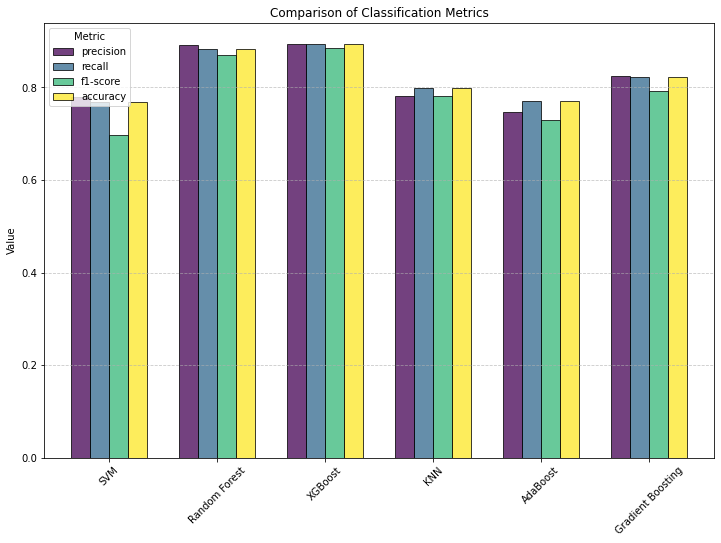

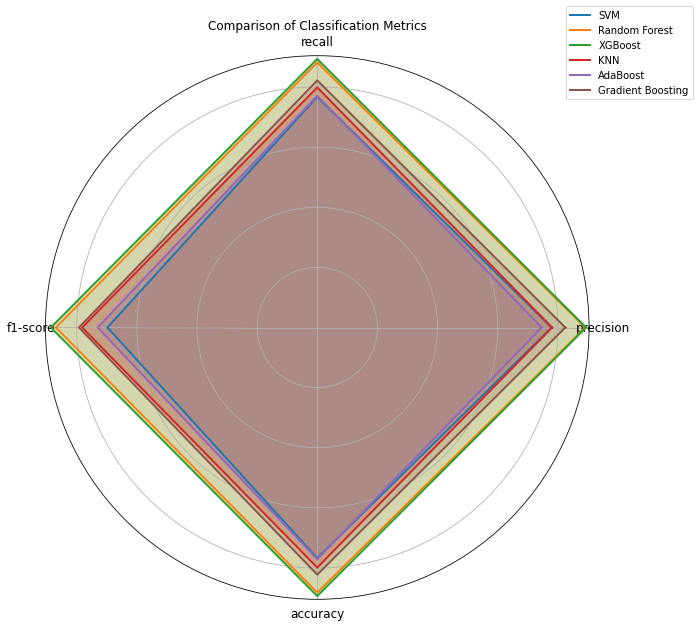

In [59]:
plot_model_comparison(results)